In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings


El set de datos Carseats, original del paquete de R ISLR y accesible en Python a través de statsmodels.datasets.get_rdataset, contiene información sobre la venta de sillas infantiles en 400 tiendas distintas. Para cada una de las 400 tiendas se han registrado 11 variables. Se pretende generar un modelo de clasificación que permita predecir si una tienda tiene ventas altas (Sales > 8) o bajas (Sales <= 8) en función de todas las variables disponibles.

In [2]:
# Lectura de datos
# ==============================================================================
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
print(carseats.__doc__)

.. container::

   .. container::

      ======== ===============
      Carseats R Documentation
      ======== ===============

      .. rubric:: Sales of Child Car Seats
         :name: sales-of-child-car-seats

      .. rubric:: Description
         :name: description

      A simulated data set containing sales of child car seats at 400
      different stores.

      .. rubric:: Usage
         :name: usage

      .. code:: R

         Carseats

      .. rubric:: Format
         :name: format

      A data frame with 400 observations on the following 11 variables.

      ``Sales``
         Unit sales (in thousands) at each location

      ``CompPrice``
         Price charged by competitor at each location

      ``Income``
         Community income level (in thousands of dollars)

      ``Advertising``
         Local advertising budget for company at each location (in
         thousands of dollars)

      ``Population``
         Population size in region (in thousands)

      ``Pric

In [3]:
datos.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


Como Sales es una variable continua y el objetivo del estudio es clasificar las tiendas según si venden mucho o poco, se crea una nueva variable binaria (0, 1) llamada ventas_altas.

In [ ]:
#no quiero que cree otra categoria, por lo que la dejo continua

In [4]:
# datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
# datos = datos.drop(columns = 'Sales')

## Ajuste del modelo y optimización de hiperparámetros

Se ajusta un modelo de clasificación empleando como variable respuesta ventas_altas y como predictores todas las variables disponibles.

In [5]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'Sales'), #TRAIN
                                        datos['Sales'], #TEST
                                        random_state = 123
                                    )

# Ordinal encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# HistGradientBoostingClassifier requiere que los valores de categoría se codifiquen
# en [0, n_unique_categories - 1], por lo que se utiliza un OrdinalEncoder para
# preprocesar los datos. Los valores missing se codifican como -1. Si una nueva
# categoría se encuentra en el conjunto de test se codifica como -1.
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
preprocessor = make_column_transformer(
                        (
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            cat_cols
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 170 to 365
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ShelveLoc    300 non-null    int64
 1   Urban        300 non-null    int64
 2   US           300 non-null    int64
 3   CompPrice    300 non-null    int64
 4   Income       300 non-null    int64
 5   Advertising  300 non-null    int64
 6   Population   300 non-null    int64
 7   Price        300 non-null    int64
 8   Age          300 non-null    int64
 9   Education    300 non-null    int64
dtypes: int64(10)
memory usage: 25.8 KB


Si bien HistGradientBoostingClassifier tiene valores por defecto para sus hiperparámetros, no se puede saber de antemano si estos son los más adecuados, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada. Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. Puede encontrarse más información sobre las estrategias de búsqueda en Machine learning con Python y Scikit-learn.

### Grid Search basado en validación cruzada

En la siguiente búsqueda de hiperparámetros, se emplea la estrategia de no incluir el número de árboles como hiperparámetro en el grid. En su lugar, se utiliza por defecto un número muy elevado y se activa la parada temprana.

En las implementaciones nativas de scikit-learn (GradientBoosting y HistGradientBoosting), el conjunto de validación para la parada temprana se extrae automáticamente de los datos de entrenamiento utilizados en cada ajuste, por lo que puede integrarse directamente en el GridSearchCV() o RandomizedSearchCV().

In [6]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {
    'max_iter'      : [50, 100, 500, 1000],
    'max_depth'     : [3, 5, 10, 20],
    'learning_rate' : [0.001, 0.01, 0.1]
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingClassifier(random_state=123, categorical_features=cat_cols),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

ValueError: 
All the 144 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/home/juan/virtual-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/juan/virtual-env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/juan/virtual-env/lib/python3.12/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 540, in fit
    y = self._encode_y(y)
        ^^^^^^^^^^^^^^^^^
  File "/home/juan/virtual-env/lib/python3.12/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 2263, in _encode_y
    check_classification_targets(y)
  File "/home/juan/virtual-env/lib/python3.12/site-packages/sklearn/utils/multiclass.py", line 222, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [9]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 500} : 0.8433333333333333 accuracy


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [10]:
modelo_final = grid.best_estimator_
modelo_final

HistGradientBoostingClassifier(categorical_features=['ShelveLoc', 'Urban',
                                                     'US'],
                               max_depth=5, max_iter=500, random_state=123)

### Predicción y evaluación del modelo

Por último, se evalúa la capacidad predictiva del modelo final empleando el conjunto de test.



In [11]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test_prep)
predicciones[:10]

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1])

Matriz de confusión
-------------------
[[38 12]
 [ 5 45]]

El accuracy de test es: 83.0 %


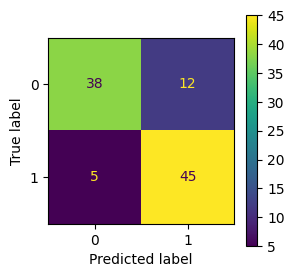

In [12]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay(mat_confusion).plot(ax=ax);

### Predicción de probabilidades

La mayoría de implementaciones de Gradient Boosting Trees, entre ellas la de scikit-learn, permiten predecir probabilidades cuando se trata de problemas de clasificación. Es importante entender cómo se calculan estos valores para interpretarlos y utilizarlos correctamente.

En el ejemplo anterior, al aplicar .predict() se devuelve  1
  (ventas elevadas) o  0
  (ventas bajas) para cada observación de test. Sin embargo, no se dispone de ningún tipo de información sobre la seguridad con la que el modelo realiza esta asignación. Con .predict_proba(), en lugar de una clasificación, se obtiene la probabilidad con la que el modelo considera que cada observación puede pertenecer a cada una de las clases.

In [13]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelo_final.predict_proba(X = X_test_prep)
predicciones[:5, :]

array([[8.35357869e-01, 1.64642131e-01],
       [2.15360382e-01, 7.84639618e-01],
       [9.99999727e-01, 2.73092904e-07],
       [8.22826079e-01, 1.77173921e-01],
       [9.99996651e-01, 3.34906400e-06]])

El resultado de .predict_proba() es un array con una fila por observación y tantas columnas como clases tenga la variable respuesta. El valor de la primera columna se corresponde con la probabilidad, acorde al modelo, de que la observación pertenezca a la clase 0, y así sucesivamente. El valor de probabilidad mostrado para cada predicción se corresponde con la fracción de observaciones de cada clase en los nodos terminales a los que ha llegado la observación predicha en el conjunto de los árboles.

Por defecto, .predict() asigna cada nueva observación a la clase con mayor probabilidad (en caso de empate se asigna de forma aleatoria). Sin embargo, este no tiene por qué ser el comportamiento deseado en todos los casos.

In [14]:
# Clasificación empleando la clase de mayor probabilidad
# ==============================================================================
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones.head(3)

,0,1,clasificacion_default_0.5
0,0.835358,1.646421e-01,0
1,0.215360,7.846396e-01,1
2,1.000000,2.730929e-07,0


Supóngase el siguiente escenario: la campaña de navidad se aproxima y los propietarios de la cadena quieren duplicar el stock de artículos en aquellas tiendas de las que se preve que tengan ventas elevadas. Como el transporte de este material hasta las tiendas supone un coste elevado, el director quiere limitar esta estrategia únicamente a tiendas para las que se tenga mucha seguridad de que van conseguir muchas ventas.

Si se dispone de las probabilidades, se puede establecer un punto de corte concreto, por ejemplo, considerando únicamente como clase  1
  (ventas altas) aquellas tiendas cuya predicción para esta clase sea superior al 0.9 (90%). De esta forma, la clasificación final se ajusta mejor a las necesidades del caso de uso.

In [15]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ==============================================================================
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.9, 1, 0)
df_predicciones[df_predicciones['clasificacion_custom_0.8']!=df_predicciones['clasificacion_default_0.5']] \
    .head(3)

,0,1,clasificacion_default_0.5,clasificacion_custom_0.8
1,0.215360,0.784640,1,0
33,0.227356,0.772644,1,0
95,0.117894,0.882106,1,0


¿Hasta que punto se debe de confiar en estas probabilidades?

Es muy importante tener en cuenta la diferencia entre la "visión" que tiene el modelo del mundo y el mundo real. Todo lo que sabe un modelo sobre el mundo real es lo que ha podido aprender de los datos de entrenamiento y, por lo tanto, tiene una "visión" limitada. Por ejemplo, supóngase que, en los datos de entrenamiento, todas las tiendas que están en zona urbana Urban='Yes' tienen ventas altas independientemente del valor que tomen el resto de predictores. Cuando el modelo trate de predecir una nueva observación, si esta está en zona urbana, clasificará a la tienda como ventas elevadas con un 100% de seguridad. Sin embargo, esto no significa que sea inequivocamente cierto, podría haber tiendas en zonas úrbanas que no tienen ventas elevadas pero, al no estar presentes en los datos de entrenamiento, el modelo no contempla esta posibilidad.

Teniendo en cuenta todo esto, hay que considerar las probabilidades generadas por el modelo como la seguridad que tiene este, desde su visión limitada, al realizar las predicciones. Pero no como la probailidad en el mundo real de que así lo sea.

### Importancia de predictores

Importancia por permutación

In [16]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train_prep,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train_prep.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
7,0.498954,0.019444,Price
0,0.454362,0.014888,ShelveLoc
3,0.364298,0.024908,CompPrice
5,0.297150,0.019205,Advertising
8,0.210673,0.016837,Age
4,0.172179,0.018822,Income
6,0.050971,0.027116,Population
1,0.000000,0.000000,Urban
2,0.000000,0.000000,US
9,0.000000,0.000000,Education


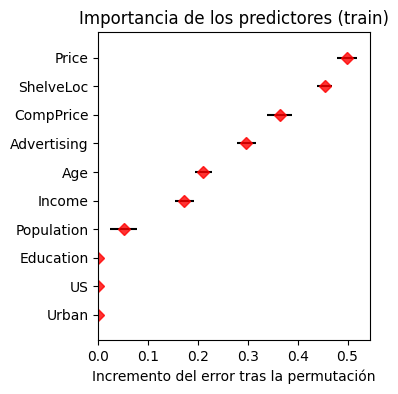

In [17]:
# Gráfico
fig, ax = plt.subplots(figsize=(3.5, 4))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

Acorde a los datos de entrenamiento, se identifican Price y ShelveLoc como los predictores más influyentes, seguidos de cerca por CompPrice y Advertising.

## Variables categóricas

En el campo del aprendizaje automático (machine learning), las variables categóricas desempeñan un papel fundamental a la hora de determinar la capacidad predictiva de un modelo. Las variables categóricas son aquellas que pueden tomar un número limitado de valores, como el color, el género o la ubicación. Si bien estas variables pueden proporcionar información útil sobre los patrones y relaciones que hay en los datos, presentan retos únicos.

Uno de estos retos es la necesidad de convertir valores categóricos en valores numéricos que puedan ser procesados por algoritmos de aprendizaje automático. Otro reto aparece al tratar con categorías poco frecuentes, que pueden dar lugar a modelos sesgados. Si una variable categórica tiene un gran número de categorías, pero algunas de ellas aparecen con poca frecuencia en los datos, el modelo puede no ser capaz de aprender de ellas dando lugar a predicciones sesgadas y resultados inexactos. A pesar de estas dificultades, las variables categóricas siguen siendo un componente esencial en muchos casos de uso. Cuando se codifican y manejan adecuadamente, pueden proporcionar información muy útil para lograr mejores predicciones.

Algunos modelos como los de XGBoost, LightGBM, CatBoost e HistGradientBoosting, son capaces de tratar predictores categóricos de forma nativa, pero asumen que las categorías son números enteros que empiezan por 0 hasta el número de categorías [0, 1, ..., n_categories-1]. En la práctica, las variables categóricas no suelen estar codificadas como números, sino con cadenas de caracteres (strings), por lo que es necesario un paso intermedio de transformación. Hay dos opciones:

Convertir las columnas con variables categóricas al tipo pandas.category. En pandas, la estructura de datos de una columna de tipo category consiste en una matriz de categorías y una matriz de valores enteros (códigos) que apuntan al valor real de la matriz de categorías. Es decir, internamente es una matriz numérica con un mapeo que relaciona cada valor con una categoría. Los modelos son capaces de identificar automáticamente las columnas de tipo category y acceder a sus códigos internos. Este enfoque es aplicable a XGBoost, LightGBM y CatBoost.

Preprocesar las columnas categóricas con un OrdinalEncoder para transformar sus valores en números enteros e indicar explícitamente que las columnas deben tratarse como categóricas. Si no se realiza este último paso, los modelos tratarán las variables como si fueran numéricas.

## LightGBM

LightGBM permite tanto la detección automática basada en el tipo de las columnas como indicar qué columnas se deben tratar como categorías (siempre que hayan sido previamente codificadas como número esteros). A continuación, se muestran las dos aproximaciones.

In [18]:
from lightgbm import LGBMClassifier

# Lectura de datos
# ==============================================================================
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# Ordinal encoding de las variables categóricas
# ==============================================================================
# Se utiliza un OrdinalEncoder para preprocesar los datos. Los valores missing se
# codifican como -1. Si una nueva categoría se encuentra en el conjunto de test
# se codifica como -1.
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
preprocessor = make_column_transformer(
                        (
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            cat_cols
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [19]:
# Entreanmiento del modelo
# ==============================================================================
modelo = LGBMClassifier(
            n_estimators = 100,
            random_state = 123
         )

# En los modelos LGBMRegressor y LGBMClassifier, el argumento categorical_feature
#  se especifica en el método fit y no durante su inicialización.
modelo.fit(X = X_train_prep, y = y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Number of positive: 186, number of negative: 114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.620000 -> initscore=0.489548
[LightGBM] [Info] Start training from score 0.489548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(random_state=123)

In [20]:
# Predicciones
# ==============================================================================
predicciones = modelo.predict(X = X_test_prep)
predicciones

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])